In [13]:
import os
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("GOOGLE_API_KEY") ## this is my google gemini api key

In [14]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings,ChatGoogleGenerativeAI
embeddings = GoogleGenerativeAIEmbeddings(model = "models/em")
llm = ChatGoogleGenerativeAI(model = "gemini-1.5-flash",api_key=api_key)

In [74]:
import os
api_key = os.getenv("OPENAI_API_KEY")



In [16]:
from langchain_openai import ChatOpenAI,OpenAIEmbeddings
llm = ChatOpenAI(model = "gpt-3.5-turbo",api_key=api_key)
embeddings = OpenAIEmbeddings(model = "text-embedding-3-small")

In [17]:
llm.invoke("who is pm of India?").content

'As of September 2021, the Prime Minister of India is Narendra Modi.'

In [18]:
## so here i am going to create the corrective rag system
## so what actually the corrective rag system
## how the corrective rag system is different from basic rag system
## in corrective rag system there are two parts
## first part is normal rag and second part is web search
## when the suer will ask any question it will go to rag 
## then we will retrieve some documents related to question
## then both the question and extracted documents will be sent to document grader
## thsi document grader will be formed of llm and prompt
## this document grader will check either the extracted document matches with suer question
## or not. if the question matches with extracted documents then we will generate teh response 
## if not then we will modify the user question using the transform query
## and this transformed query will be sent to web search
## and what ever docuuments we will extarct from web search 
## those documnents along with user question will be sent to llm
## in order to generate the response


In [19]:
## first i will create the rag  system
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]
docs = [WebBaseLoader(url).load() for url in urls] ## i loaded text data from website to my local system
docs_list = [item for sublist in docs for item in sublist] ## i put all data from all websites in a single list
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 200,chunk_overlap = 10) ## created text splitter 
docs_split = text_splitter.split_documents(docs_list) ## splitted my text data into chunks
## now i will be creating the vector store where whole text data will be stored in form of word vector embeddings
vectorstore = Chroma.from_documents(
    documents=docs_split,
    embedding=embeddings,
    collection_name="rag-chrome"
)


In [20]:
## till here i have created my vector store
## where whole text data is stored in vector databse in form of word vector embeddings
## now i will create the retriever on top of this vectorstore
## so that i can retrieve the relevant documents form the vector database

In [21]:
retriever = vectorstore.as_retriever()

In [22]:
## now i will create the rag chain of this retriever
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
prompt = hub.pull("rlm/rag-prompt")
print(prompt)
rag_chain = prompt | llm | StrOutputParser()


c:\corrective_rag1\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


In [23]:
question = "what is agentic ai?"
documents = retriever.invoke(question)
response = rag_chain.invoke({"question":question,"context":documents})
print(response) ## so my normal rag system is working fine

Agentic AI refers to autonomous agent systems where a large language model (LLM) serves as the core controller. LLM functions as the agent's brain, with key components like planning, memory, and tool use supporting its operations. This setup allows the agent to efficiently handle complex tasks, reflect on past actions, and leverage external resources for additional information.


In [24]:
documents[0]

Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizi

In [25]:
## so let us create the document grader
from langchain_core.prompts import ChatPromptTemplate ##
from langchain_core.pydantic_v1 import BaseModel, Field

class Grader(BaseModel):
    "binary_score for relevance check on the retriever documents"
    binary_score:str = Field(
        description="Documents are relevant to the question 'yes' or 'no' "
    )

c:\corrective_rag1\venv\lib\site-packages\IPython\core\interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [26]:
llm_structured = llm.with_structured_output(Grader)
system = """You are a document grader. You will be given a question and documents.If the question is relevant to
the documents then you will return binary_score = 'yes' and if the question is not relevant to documents
then you will return binary_score = 'no'.check the question and document carefully then only make any decision  
             
         """
grade_prompt = ChatPromptTemplate.from_messages(
    [("system",system),
     ("human", "documents/n/n{documents} and question/n/n {question}")]

)
document_grader = grade_prompt| llm_structured

c:\corrective_rag1\venv\lib\site-packages\langchain_openai\chat_models\base.py:1362: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
c:\corrective_rag1\venv\lib\site-packages\langchain_openai\chat_models\base.py:1375: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [27]:
## i created the document grader
## now i will check either my document grader is working fine or not


In [28]:
question = "what is agentic ai?"
documents = retriever.invoke(question)
binary_score =document_grader.invoke({"question":question,"documents":documents})

In [29]:
print(binary_score)

binary_score='yes'


In [30]:
question = "who is the PM of India?"
documents = retriever.invoke(question)
binary_score =document_grader.invoke({"question":question,"documents":documents})

In [31]:
documents[0]

Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizi

In [32]:
print(binary_score)

binary_score='no'


In [33]:
## now i will create the question rewritter
## so why and where the question rewriter will be used
## when documents along with the question will be sent to document grader
## of w eget binary_score = no
## means these documents are not realate dto question
## then that question will be sent to do web search
## before sending the question to websearch i will rewrite teh question
## so that it can extract the maximum information from the website

In [34]:
system = """  You are a question rewriter. You will be given a question. Your job is to understand the context of the question carefully
and update the question so that we can extract maximum information with the help of this question.Do not add any extra thing to questio.
if you are not able to do some addition on it .let the question as it as.
              
               """
prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","question:{question}")
    ]
)

question_rewriter = prompt | llm | StrOutputParser()

In [35]:
question_rewriter.invoke("who is the pm of India?") ## so my question rewriter is working fine as of now

'Who currently holds the position of Prime Minister in India?'

In [36]:
## now creating all the functions for the graph which will act as the nodes inside the graph
def retrieve(state):
    "This function will retrieve the relevant documents from the vector database based on the user question"
    question = state["question"] 
    documents = retriever.get_relevant_documents(question)

    return {"question":question,"documents":documents}

In [37]:
def grade_documents(state):
    "This function will grade documents based on the question"
    question = state["question"] ## user question
    documents = state["documents"] ## documents fetched form the vector datavbase

    filtered_docs = []
    web_search = "no"

    for d in docs:
        score = document_grader.invoke({"question":question,"documents":d})
        binary_score = score.binary_score
        if binary_score == "yes":
            filtered_docs.append(d)
        else:
            web_search = "yes"
    return {"question":question,"documents":filtered_docs,"web_search":web_search}

In [58]:
def generate(state):
    "This function will generate response based on the question and the retrieved documents, this will be used if web_search == 'no' "
    question = state["question"]
    documents = state["documents"]

    generated_response = rag_chain.invoke({"question":question,"context":documents})

    return {"question":question,"documents":documents,"response":generated_response}



In [39]:
## writting query rewritter function
def transform_query(state):
    "This function will rewrite the query, so that this query may able to fetch maximum information from the web search"
    question = state["question"]
    documents = state["documents"]

    new_question = question_rewriter.invoke({"question":question})
    return {"question":new_question,"documents":documents}


In [40]:
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [41]:
import os

# Set your Tavily API key
os.environ["TAVILY_API_KEY"] = tavily_api_key


In [42]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(k=3)

In [43]:
query = "who is the prime minister of India"
response = tavily_search.invoke({"query":question})
response

[{'url': 'https://www.pmindia.gov.in/en/pms-profile/',
  'content': 'Shri Narendra Modi was sworn-in as India’s Prime Minister for the third time on 9th June 2024, following another decisive victory in the 2024 Parliamentary elections. The first ever Prime Minister to be born after Independence, Shri Modi has previously served as the Prime Minister of India from 2014 to 2019, and from 2019 to 2024. Leading international agencies have noted that under the leadership of PM Narendra Modi, India has been eliminating poverty at record pace. In June 2024, after assuming office for the third term, one of the first decisions of the Cabinet was to assist 3 crore additional rural and urban households for the construction of houses, underscoring Shri Narendra Modi’s commitment to addressing the nation’s housing needs and ensuring dignity and a quality life for every citizen. PM Modi launched the ‘Make in India’ initiative to turn India into an international manufacturing powerhouse.'},
 {'url': '

In [44]:
content = "/n".join([d["content"] for d in response])

In [45]:
content = [d["content"] for d in response]
content

['Shri Narendra Modi was sworn-in as India’s Prime Minister for the third time on 9th June 2024, following another decisive victory in the 2024 Parliamentary elections. The first ever Prime Minister to be born after Independence, Shri Modi has previously served as the Prime Minister of India from 2014 to 2019, and from 2019 to 2024. Leading international agencies have noted that under the leadership of PM Narendra Modi, India has been eliminating poverty at record pace. In June 2024, after assuming office for the third term, one of the first decisions of the Cabinet was to assist 3 crore additional rural and urban households for the construction of houses, underscoring Shri Narendra Modi’s commitment to addressing the nation’s housing needs and ensuring dignity and a quality life for every citizen. PM Modi launched the ‘Make in India’ initiative to turn India into an international manufacturing powerhouse.',
 "Also, as the Minister of Personnel, Public Grievances and Pensions, the PM a

In [49]:
from langchain.schema import Document

In [50]:
def net_search(state):
    question = state["question"]
    documents = state["documents"]
    response = tavily_search.invoke({"query":question})
    content = "/n".join([d["content"] for d in response])
    document = Document(page_content=content)
    documents.append(document)
    return {"question":question,"documents":documents}


In [51]:
## now writting the function which will decide
## either to generate or transform the query
def decide_to_generate(state):
    "this function takes the decision either to generate or transform the query"
    question = state["question"]
    documents = state["documents"]
    web_search = state["web_search"]

    if web_search == "yes":
        return "transform_query"
    else:
        return "generate"

In [52]:
## now i will be creating the graph
from langgraph.graph import StateGraph,START,END
from typing import List
from typing_extensions import TypedDict

In [59]:
class State(TypedDict):
    question:str
    documents:List[str]
    web_search:str
    response:str
    
workflow = StateGraph(State)

workflow.add_node("retrieve",retrieve)
workflow.add_node("document_grader",grade_documents)
workflow.add_node("generate",generate)
workflow.add_node("net_search",net_search)
workflow.add_node("transform_query",transform_query)
## created all the nodes now i will be creating all the edges
workflow.add_edge(START,"retrieve")
workflow.add_edge("retrieve","document_grader")
## now using conditional edge
workflow.add_conditional_edges("document_grader",decide_to_generate,{"transform_query":"transform_query","generate":"generate"})
workflow.add_edge("transform_query","net_search")
workflow.add_edge("net_search","generate")
workflow.add_edge("generate",END)

In [60]:
app = workflow.compile()

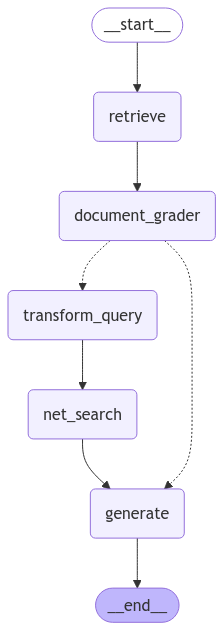

In [61]:
# Display the graph
from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
## till here i have created my graph
## now i will test my graph 
## is it working fine or not
## i love creating graphs for ai agents

In [62]:
from pprint import pprint
inputs = {"question":"tell me about agnet memory"}

In [64]:
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["response"])

"Node 'retrieve':"
'\n---\n'
"Node 'document_grader':"
'\n---\n'
"Node 'transform_query':"
'\n---\n'
"Node 'net_search':"
'\n---\n'
"Node 'generate':"
'\n---\n'
('Agent memory in the context of cognitive processes refers to both short-term '
 'memory through context windows and long-term memory through techniques like '
 'Retrieval-Augmented Generation (RAG). Short-term memory allows models to '
 'learn from in-context information, while long-term memory enhances '
 'information retention and recall over extended periods by leveraging '
 'techniques like RAG. The interplay between short-term and long-term memory '
 'is essential for developing more human-like AI responses.')


In [66]:
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")
# Final generation
pprint(value["response"])

IndentationError: expected an indented block after 'for' statement on line 1 (1492874160.py, line 9)

In [67]:
response = app.stream(inputs)

In [68]:
response

<generator object Pregel.stream at 0x0000024C24760040>

In [69]:
response = app.invoke(inputs)

In [72]:
response["response"]

'Agent memory refers to the mechanisms used by AI agents to retain and recall information over short and extended periods. It involves short-term memory through context windows and long-term memory using methods like Retrieval-Augmented Generation (RAG). These memory components are crucial for enabling more coherent and informed responses in AI agents.'

In [73]:
question = "who is pm of India"
inputs = {"question":question}
response = app.invoke(inputs)
response

{'question': 'Who currently holds the position of Prime Minister in India?',
 'documents': [Document(metadata={}, page_content="To hold the position of Prime Minister (PM), one must be a member of the political party or coalition that holds a majority in the Lok Sabha, one of India's two houses of parliament. The Rajya Sabha, also known as the Council of the States, is the other house. Currently, Narendra Damodardas Modi holds the position of Prime Minister of India./nCurrently, Prime Minister Narendra Modi holds the position as the 14th Prime Minister of India. He has served two consecutive terms and becomes the fourth Indian Prime Minister to achieve this feat and the first non-Congress Prime Minister to do so. Note: The Prime Minister of India is the leader of the government in the Republic of India/nNarendra Modi is the current prime minister of India for the 3rd consecutive term since 2014. In this article, we have provided the List of Prime Ministers of India From 1947 to 2024. .